##  Прогнозирование заказов такси

### Задача:

Компания, предоставляющая услуги такси, собрала исторические данные о заказах такси в аэропортах. 

Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Построим модель для такого предсказания.

План работ:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные в файле `taxi.csv`. Количество заказов в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
data = pd.read_csv('/datasets/taxi.csv',index_col=[0],parse_dates = [0])
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

In [2]:
print(data.head())

                     num_orders
datetime                       
2018-03-01 00:00:00           9
2018-03-01 00:10:00          14
2018-03-01 00:20:00          28
2018-03-01 00:30:00          20
2018-03-01 00:40:00          32


In [3]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB
None


Проверим последовательно ли расположены данные

In [4]:
print(data.index.is_monotonic)

True


Выполним ресемплирование по 1му часу

In [5]:
data = data.resample('1H').sum()

## Анализ

введем скользящее среднее

In [6]:
data['rolling'] = data['num_orders'].rolling(50).sum()
data['rolling_std'] = data['num_orders'].rolling(50).std()

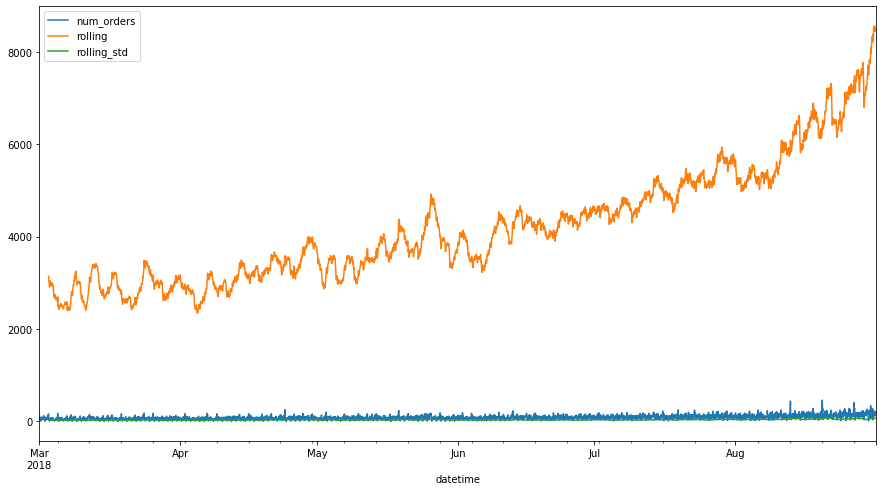

In [7]:
data.plot(figsize = (15,8))

Визуально прослеживается тренд - увеличение количества заказов, проверим средствами tsa.seasonal 

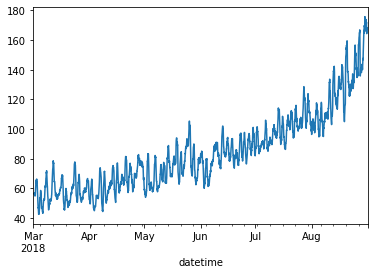

In [8]:
decomposed = seasonal_decompose(data['num_orders']) 
decomposed.trend.plot()

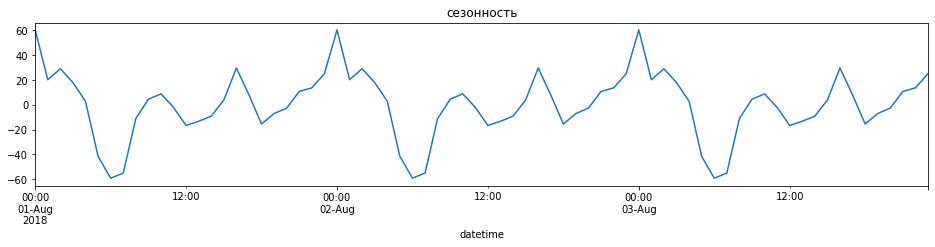

In [9]:
plt.figure(figsize=(16, 3))
plt.title('сезонность')
plt.gca()
decomposed.seasonal['2018-08-01':'2018-08-03'].plot(ax=plt.gca())
plt.show()

> Вывод: прослеживается сезонность максимальное количество заказов в 24 часа и после этого спад к минимальному значению в 6 утра

## Обучение

Подготовим признаки для модели

In [10]:
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    for rolling_mean in range(1, rolling_mean_size + 1):
        data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean).mean()

In [11]:
#make_features(data, 23, 2)

In [12]:
data['month'] = data.index.month
data['day'] = data.index.day
data['dayofweek'] = data.index.dayofweek
data['hour'] = data.index.hour

разобьем выборки на тренировочную, валидационную и тестовую в соотношении 80/10/10

In [13]:
train, x = train_test_split(data, test_size = 0.2, shuffle = False)
valid, test = train_test_split(x, test_size = 0.5, shuffle = False)
train = train.dropna()

target_train = train['num_orders']
target_valid = valid['num_orders']
target_test = test['num_orders']
features_train = train[['month','day','dayofweek','hour']]
features_valid = valid[['month','day','dayofweek','hour']]
features_test = test[['month','day','dayofweek','hour']]

## Тестирование

Тестируем модель регрессии

In [14]:
model_regr = LinearRegression()
model_regr.fit(features_train, target_train)
predicted_regr = model_regr.predict(features_valid)

rmse_regr = (mean_squared_error(target_valid, predicted_regr))**0.5
print(rmse_regr)

46.709966576886835


Тестируем модель дерева

In [15]:
def model_tr(depth):
    rmse = 1000
    best_depth = []
    for i in range (1,depth):
        model_tree = DecisionTreeRegressor(random_state = 12345, max_depth = i)
        model_tree.fit(features_train,target_train)
        predicted_tree = model_tree.predict(features_valid)
        rmse_tree = (mean_squared_error(target_valid, predicted_tree))**0.5
        if rmse_tree < rmse:
            rmse = rmse_tree
            best_depth = i
    print ('лучшее значение RMSE: ',rmse,'лучшие параметры max_depth: ', best_depth)
model_tr(50)

лучшее значение RMSE:  34.86476693132582 лучшие параметры max_depth:  9


Тестируем модель леса

In [16]:
model_forest = RandomForestRegressor(random_state = 12345, max_depth = 22,n_estimators = 30)
model_forest.fit(features_train,target_train)
predicted_forest = model_forest.predict(features_valid)
rmse_forest = (mean_squared_error(target_valid, predicted_forest))**0.5
print(rmse_forest)

33.09407223194074


 ### Модель с наилучшими показателями протестируем на тестовой выборке

In [17]:
united_features = pd.concat([features_train, features_valid], axis = 0)
united_target = pd.concat([target_train, target_valid], axis = 0)
print(united_features.index.is_monotonic)

True


In [18]:
model_forest.fit(united_features,united_target)
predicted_forest_test = model_forest.predict(features_test)
rmse_forest_test = (mean_squared_error(target_test, predicted_forest_test))**0.5
print(rmse_forest_test)

45.96762277081664


## Вывод

Модель леса деревьев хорошо показала себя при правильных настройках на валидационной выборке, её качество (корень из квадратичной ошибки) при проверке на тестовой составило 45